Ce notebook présente différentes méthodes permettant de prédire les valeurs futures d'une série chronologique. Le cas d'application considéré concerne les données de l'agence ORE (Opérateurs des réseaux d'énérgie), plus précisément la consommation agrégée demi-horaire des points de soutirage inférieurs à 36 kVA (téléchargées depuis ce [lien](https://www.agenceore.fr/opendata/consommation-agregee-demi-horaire-des-points-de-soutirage-inferieurs-36kva-par-region)). 

L’Agence ORE (Opérateurs de Réseaux d’Énergie) fédère l’ensemble des acteurs français de la distribution d’électricité et de gaz, pour offrir une vision globale de la distribution en France, en un guichet unique et gratuit de la donnée. Elle met à disposition la donnée électricité et gaz, multi-gestionnaires de réseaux de distribution pour accompagner la transition énergétique dans les territoires français, en open data et sous forme de datavisualisations

In [1]:
import matplotlib.pyplot as plt
from prophet import Prophet
import pandas as pd
from agence_ore_data import manage_date_in_df, select_part_of_data_frame
import numpy as np

/home/thibaut/anaconda3/envs/time_series_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Commençons par charger les données. Avec la fonction manage_data_in_df, on ajoute aux données des colonnes représentant des variables exogènes  qui pourront être utilisés en entrée des modèles pour simplifier la prédiction. Ces variables sont le jour de la semaine, le jour de l'année et l'heure de la journée ainsi que leurs encodeages sinusoïdaux (en effet le 31 décembre étant très proche du 1er janvier, il faut que les modèles aient cette information de circularité).

In [2]:
df = pd.read_csv("data/consommation_inf_36Kva.csv", delimiter=";")
df = df.fillna(method='bfill')
manage_date_in_df(df, utc=True)  

/tmp/ipykernel_5694/973934260.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')
/home/thibaut/Documents/project_temporal_series/agence_ore_data.py:39: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['HORODATE'] = pd.to_datetime(df['HORODATE'], infer_datetime_format=True, utc=utc)


Ensuite, nous selectionnons et visualisons une partie du jeu de données correspondant à la consommation des points de soutirage (inférieurs à 36kVa) de la région Bretagne. La consommation est exprimée en Wh. Nous la divisions par $10^9$ car les modèles d'apprentissages peinent à traiter des nombres aussi grands. 

In [3]:
region = 'Bretagne'
df_bretagne = select_part_of_data_frame(df, select_all=True, region=region)
df_bretagne["ENERGIE_SOUTIREE"] /= 10 ** 9
sequence = df_bretagne["ENERGIE_SOUTIREE"].to_numpy()

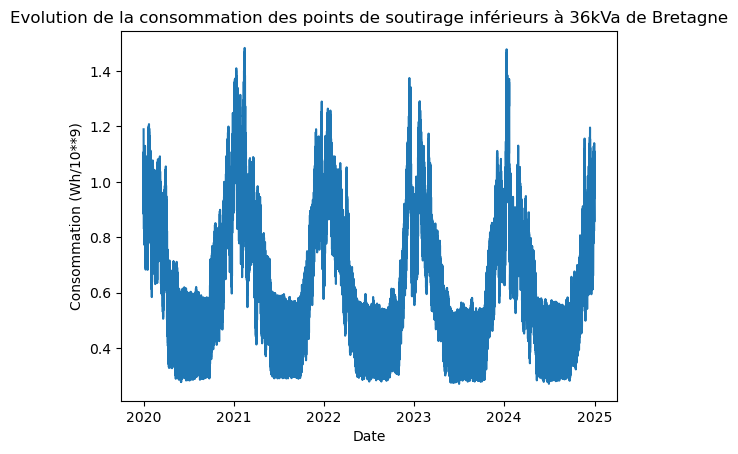

In [4]:
plt.plot(df_bretagne['HORODATE'], df_bretagne["ENERGIE_SOUTIREE"])
plt.xlabel('Date')
plt.ylabel('Consommation (Wh/10**9)')
plt.title('Evolution de la consommation des points de soutirage inférieurs à 36kVa de Bretagne' )
plt.show()

Zoomons sur le fin du graphe

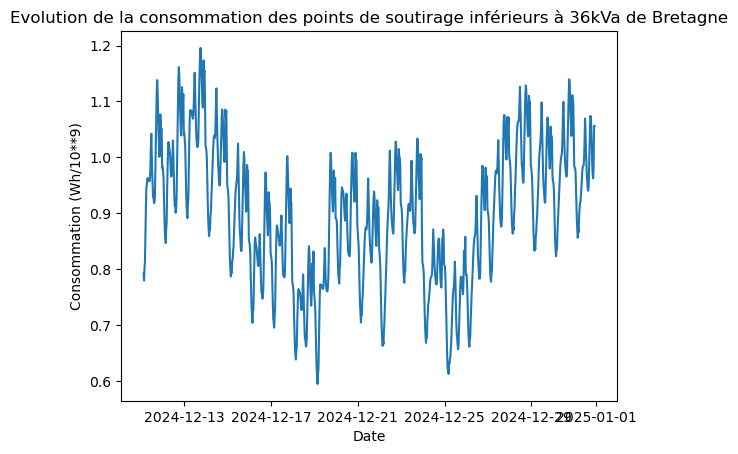

In [5]:
deb = -1000
fin = -1
plt.plot(df_bretagne['HORODATE'][deb:fin], df_bretagne["ENERGIE_SOUTIREE"][deb:fin])
plt.xlabel('Date')
plt.ylabel('Consommation (Wh/10**9)')
plt.title('Evolution de la consommation des points de soutirage inférieurs à 36kVa de Bretagne' )
plt.show()

A partir des valeurs passées de cette série temporelle, nous cherchons à prédire les valeurs futures. N'ayant pas accès aux valeurs futurs pour valider la méthode, nous séparons la série temporelle en une partie qui sera utilisée pour entrainer nos modèles, et une partie utilisée pour la validation. 

Dans un premier temps, nous entraînons un modèle Prophet sur notre jeu de données. Ce modèle, développé par Facebook, permet de modéliser une série temporelle comme la somme de trois composantes : une composante de tendance, modélisée comme une fonction affine par morceaux ; une composante saisonnière, modélisée comme une combinaison linéaire de fonctions sinusoïdales ; et une composante permettant de prendre en compte la présence de jours spéciaux (Noël, jours fériés). À noter que ces trois composantes dépendent uniquement de la variable temporelle : le modèle cherche à apprendre la fonction qui associe la consommation à l’horaire considéré. Autrement dit, il n’y a pas de modélisation autorégressive permettant d’apprendre la dépendance de la série à un instant en fonction des valeurs aux instants précédents.

Le modèle Prophet est particulièrement adapté à la modélisation de l’évolution de la consommation électrique, car cette dernière présente deux formes de saisonnalité : une saisonnalité journalière et une saisonnalité annuelle.

In [6]:
exog_variables = df_bretagne[['hour_sin', 'dayofweek_sin', 'dayofyear_sin']].to_numpy()
nb_test_vals = 10000

df_prohet = pd.DataFrame(columns=['ds', 'y'])
df_prohet['ds'] = df_bretagne['HORODATE'].dt.tz_localize(None)
print('horodate', df_prohet['ds'])
df_prohet['y'] = df_bretagne["ENERGIE_SOUTIREE"]
print('head', df_prohet.head())

df_prohet_train = df_prohet.iloc[:-nb_test_vals, :]
df_prohet_test = df_prohet.iloc[-nb_test_vals:, :]



prohet_mod = Prophet()
prohet_mod.fit(df_prohet_train)



horodate 666727    2019-12-31 23:00:00
23324     2019-12-31 23:30:00
666740    2020-01-01 00:00:00
552826    2020-01-01 00:30:00
552833    2020-01-01 01:00:00
                  ...        
1218854   2024-12-31 20:30:00
1298492   2024-12-31 21:00:00
1278868   2024-12-31 21:30:00
1218870   2024-12-31 22:00:00
1218875   2024-12-31 22:30:00
Name: ds, Length: 87696, dtype: datetime64[ns]
head                         ds         y
666727 2019-12-31 23:00:00  1.189607
23324  2019-12-31 23:30:00  1.128238
666740 2020-01-01 00:00:00  1.125954
552826 2020-01-01 00:30:00  1.123714
552833 2020-01-01 01:00:00  1.113096


15:27:07 - cmdstanpy - INFO - Chain [1] start processing
15:27:28 - cmdstanpy - INFO - Chain [1] done processing


Nous pouvons maintenant effectuer une prédiction pour les pas de temps futurs et comparer la prédiction du modèle aux valeurs réelles 

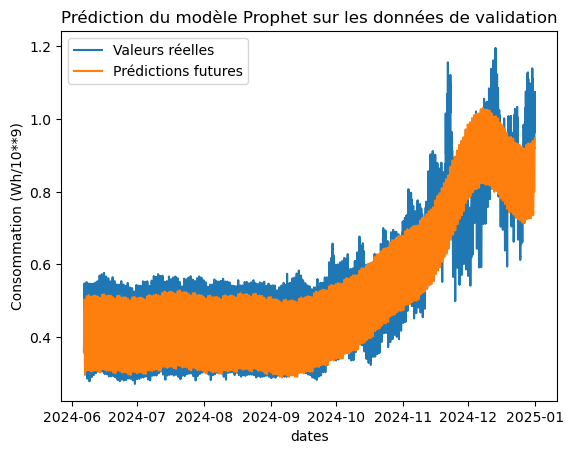

In [7]:
prediction_time_stamps = df_prohet_test[['ds']]
forecast = prohet_mod.predict(prediction_time_stamps)
plt.plot(prediction_time_stamps, df_prohet_test['y'], label="Valeurs réelles")
plt.plot(prediction_time_stamps, forecast['yhat'], label="Prédictions futures")
plt.xlabel("dates")
plt.ylabel('Consommation (Wh/10**9)')
plt.title('Prédiction du modèle Prophet sur les données de validation')
plt.legend()
plt.show()

Nous pouvons également tracer l'ensemble des prédictions (sur les données d'entrainement + les données de validation)

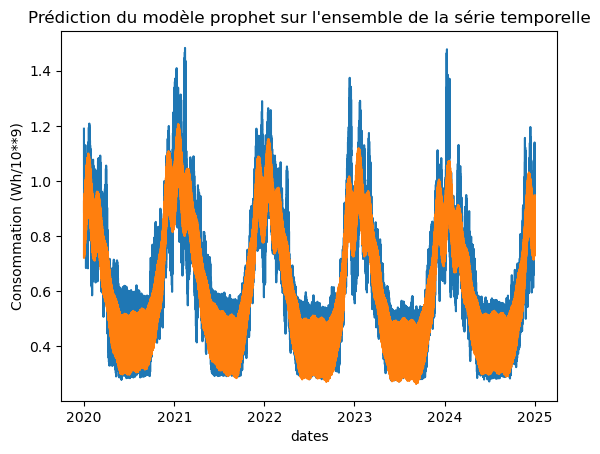

In [9]:
prediction_time_stamps_all = df_prohet[['ds']]
forecast_all = prohet_mod.predict(prediction_time_stamps_all)
plt.plot(prediction_time_stamps_all, df_prohet['y'])
plt.plot(prediction_time_stamps_all, forecast_all['yhat'])
plt.xlabel("dates")
plt.ylabel('Consommation (Wh/10**9)')
plt.title("Prédiction du modèle prophet sur l'ensemble de la série temporelle") 
plt.show()

Nous pouvons constater que la prédiction est relativement fidèle à l'allure générale de la série temporelle, bien que l'erreur soit non négligeable. Nous cherchons maintenant à répondre à la question : les résidus sont ils indépendants et uniformément distribués ?

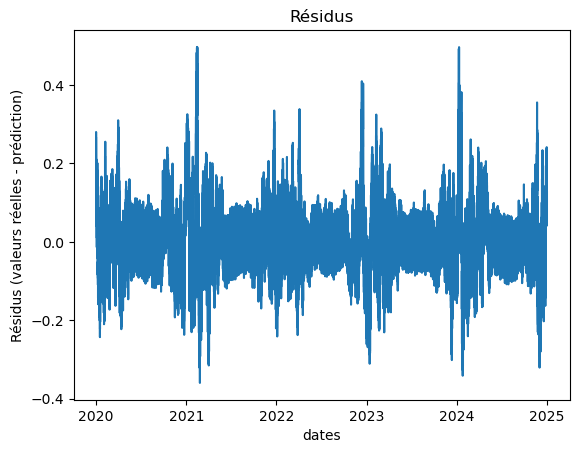

In [10]:
residual = df_prohet['y'].values - forecast_all['yhat'].values
plt.plot(prediction_time_stamps_all, residual)
plt.xlabel("dates")
plt.ylabel("Résidus (valeurs réelles - prédiction)")
plt.title("Résidus")
plt.show()

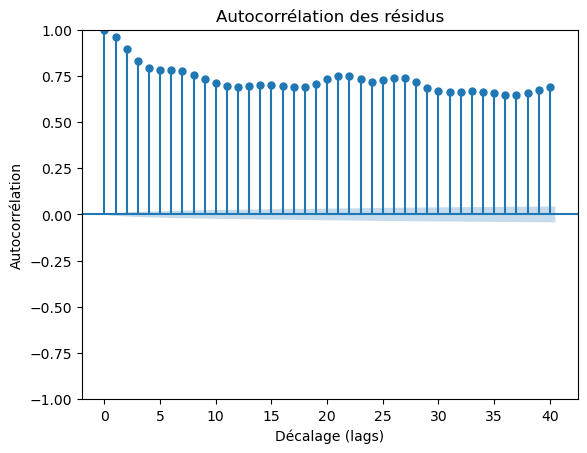

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
# Tracer l'autocorrélation
plot_acf(residual, lags=40)  # Ajuste le nombre de lags si besoin
plt.xlabel("Décalage (lags)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

Nous pouvons constater à partir de ces deux graphes que :

- Les résidus ne sont pas uniformément distribués (en particulier, ils ont tendance à être plus élevés lors des périodes de forte consommation d'électricité en hiver).

- Les résidus ne sont pas décorrélés (et donc également non indépendants), car la fonction d'autocorrélation est très éloignée d’un Dirac. La modélisation par Prophet n’est donc pas suffisante pour capturer la complexité du processus stochastique. En effet, le modèle Prophet tente simplement d’apprendre une dépendance des valeurs de la série en fonction du temps. Or, pour de nombreux processus stochastiques, la valeur à l’instant t est fortement influencée par les valeurs aux instants précédents. Il est donc important d’ajouter à notre modèle une composante auto-régressive qui modélise explicitement cette dépendance.

Dans la suite du notebook, nous allons affiner la prédiction en entraînant des modèles d’apprentissage sur les résidus afin de modéliser la dépendance des résidus à l’instant t en fonction des résidus aux instants précédents. Pour cela, nous utiliserons deux modèles courants : un modèle de Transformers et un modèle LSTM.

Dans un premier temps, sauvegardons les résidus et les varaibles exogènes qui les accompagnent. 

In [12]:
time_stamp_chars = ['HORODATE', 'hour_of_day', 'day_of_week', 'day_of_year', 'hour_sin', 'dayofweek_sin', 'dayofyear_sin']
prophet_results_df = pd.DataFrame(columns=['y', 'prophet_pred', 'resiudals', 'ds']+ time_stamp_chars)

prophet_results_df['prophet_pred'] = forecast_all['yhat'].values
prophet_results_df['y'] = df_prohet['y'].values
prophet_results_df['resiudals'] = residual
prophet_results_df['ds'] = df_prohet['ds'].values
for g in time_stamp_chars:
    prophet_results_df[g] = df_bretagne[g].values
print('shape df', prophet_results_df.shape)
prophet_results_df.to_csv('prohet_modelisation.csv')

shape df (87696, 11)


Nous allons maintenant entrainer un modèle transformeur *sequence to sequence* sur ces résidus. le principe est d'apprendre la fonction qui fait correspondre N valeurs consécutives de la série temporelle au N valeurs suivantes. Ce modèle transformeur prend également en entrée les variables exogènes présentes (celles associées à la séries mises en entrée) et futures, celles associées aux valeurs futures que l'on souhaite prédire. Une fois l'entrainement terminée, nous pouvons faire une prédiction à un horizon de temps N en additionant l'estimation du modèle prophet à l'estimation du modèle tranformeur. 

In [13]:
import pandas as pd
from trasnformers_2 import train_time_series_seq_to_seq_transformer, to_tensor, to_numpy
df = pd.read_csv('prohet_modelisation.csv')

In [21]:
print('df', df.shape)
exogeneous_variables = ['hour_sin', 'dayofweek_sin', 'dayofyear_sin']
nb_test_vals = 800
df_train, df_test = df.iloc[:-nb_test_vals], df.iloc[-nb_test_vals:]
df_train_y = df_train['resiudals']
df_train_exogenous = df_train[exogeneous_variables]
df_test_exogenous = df_test[exogeneous_variables]

train_y = to_tensor(df_train_y.values)
train_exogenous = to_tensor(df_train_exogenous.to_numpy())
test_exogenous = to_tensor(df_test_exogenous.to_numpy())

window_size = 100 #  horizon temporelle de prédiction (en nombre de time stamps) et taille de la fenêtre d'entrée
n_epochs = 300
model, _, _, _, _ = train_time_series_seq_to_seq_transformer(train_y, train_exogenous, window_size, n_epochs)

df (87696, 12)
ep 0


/home/thibaut/anaconda3/envs/time_series_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


loss epoch 0.010394888
ep 1
loss epoch 0.006126446
ep 2
loss epoch 0.005781035
ep 3
loss epoch 0.005778116
ep 4
loss epoch 0.0058252895
ep 5
loss epoch 0.0050462927
ep 6
loss epoch 0.0051062517
ep 7
loss epoch 0.004685661
ep 8
loss epoch 0.0048679584
ep 9
loss epoch 0.004758411
ep 10
loss epoch 0.0046534697
ep 11
loss epoch 0.0044252337
ep 12
loss epoch 0.0043102126
ep 13
loss epoch 0.004362534
ep 14
loss epoch 0.004457205
ep 15
loss epoch 0.0042538904
ep 16
loss epoch 0.0043050027
ep 17
loss epoch 0.0042070937
ep 18
loss epoch 0.0040732156
ep 19
loss epoch 0.003788749
ep 20
loss epoch 0.0035459793
ep 21
loss epoch 0.0032932507
ep 22
loss epoch 0.0030081621
ep 23
loss epoch 0.0028790217
ep 24
loss epoch 0.0026725272
ep 25
loss epoch 0.0024444854
ep 26
loss epoch 0.0023092267
ep 27
loss epoch 0.0022202712
ep 28
loss epoch 0.0021024514
ep 29
loss epoch 0.0020684549
ep 30
loss epoch 0.0019311559
ep 31
loss epoch 0.0018974359
ep 32
loss epoch 0.0018675359
ep 33
loss epoch 0.0018407897
ep 3

In [23]:
print(len(df_test['prophet_pred'].to_numpy()))

800


Nous pouvons maintenant effectuer une prédiction à l'aide du modèle entrainé. Le modèle permet uniquement de prédire à l'horizon temporel *window_size*, pour prédire au delà de cet horizon, nous devons utiliser de manière itérative les valeurs prédites comme nouvelles entrées du modèle. Cette approche est néanmoins sujette à l'accumulation des erreurs

Index(['Unnamed: 0', 'y', 'prophet_pred', 'resiudals', 'ds', 'HORODATE',
       'hour_of_day', 'day_of_week', 'day_of_year', 'hour_sin',
       'dayofweek_sin', 'dayofyear_sin'],
      dtype='object')
len1 200
len2 800


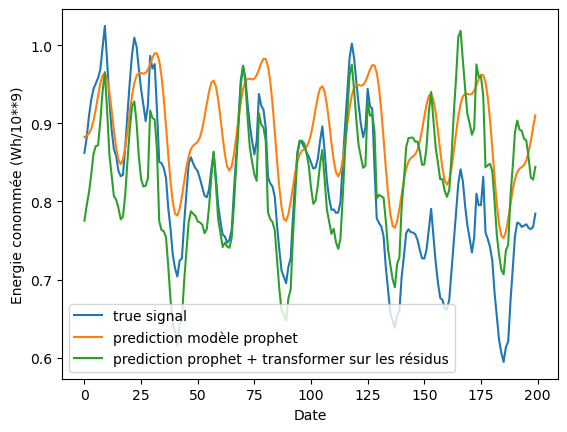

In [55]:
print(df_test.columns)
predicted_residuals = model.long_term_forecasting(train_y[-window_size:], train_exogenous[-window_size:], test_exogenous, 199)
predicted_residuals = to_numpy(predicted_residuals)
print('len1', len(predicted_residuals))
print('len2', len(df_test['prophet_pred'].to_numpy()))
predicted_signal_plus_residuals = predicted_residuals + df_test['prophet_pred'].to_numpy()[:len(predicted_residuals)] - 0.1
#X_axis = df_bretagne['HORODATE'][-nb_test_vals:]
true_signal = df_test['y'].to_numpy()[:len(predicted_residuals)]
prophet_pred = df_test['prophet_pred'].to_numpy()[:len(predicted_residuals)]
plt.plot(true_signal, label='true signal')
plt.plot(prophet_pred, label='prediction modèle prophet')
plt.plot(predicted_signal_plus_residuals, label='prediction prophet + transformer sur les résidus')
plt.xlabel('Date')
plt.ylabel("Energie conommée (Wh/10**9)")
plt.legend()
plt.show()

In [ ]:
#prediction sur une partie du jeu d'entrainement
h = 8
predicted_residuals_train = model.forward(train_y[-h*window_size:-(h-1)*window_size], train_exogenous[-h*window_size:-(h-1)*window_size], 
                                          train_exogenous[-(h-1)*window_size:-(h-2)*window_size])
predicted_residuals_train = to_numpy(predicted_residuals_train)
prophet_pred_train = df_train['prophet_pred'].to_numpy()[-(h-1)*window_size:-(h-2)*window_size]
true_signal_train = df_train['y'].to_numpy()[-(h-1)*window_size:-(h-2)*window_size]
plt.plot(true_signal_train, label='true signal')
plt.plot(prophet_pred_train, label='prediction modèle prophet')
plt.plot(predicted_residuals_train + prophet_pred_train, label='prediction prophet + transformer sur les résidus')
plt.xlabel('Date')
plt.ylabel("Energie conommée (Wh/10**9)")
plt.legend()
plt.show()

Ci-dessous, nous calculons la MSE associée à la prédiction du modèle prohpet et la MSE associée à la prédiction du modèle sommant la prédiction du moèle prophet et la prédiction du modèle transformer entrainé sur les résidus. Nous pouvons constater que la MSE est légérement améliorée lorsqu'on utilsie la seconde méthode. Nénamoins, l'amélioration est relativement faible, et cela est du à l'accumulation des erreurs pour la prédiction à long terme au delà de la fenêtre d'horizon de prédiction. Il est donc également peritent de visualiser comment évolue cette MSE loesque l'on augement l'horizon de prédiction. C'est l'objet du graphe suivant. 

In [56]:
mse_prophet = np.mean(df_test['resiudals'].to_numpy()**2)
mse_prophet_transformer = np.mean((predicted_signal_plus_residuals - true_signal)**2)
print('mse prophet', mse_prophet)
print('mse prophet + transformer on residuals', mse_prophet_transformer)

mse prophet 0.010508581319934863
mse prophet + transformer on residuals 0.007205717390413706


In [57]:
def mse_at_different_horizons(pred_sequence, ref_sequence, window_lenght=100):
    mses = []
    for i in range(len(pred_sequence)-window_lenght):
        mse = np.mean((pred_sequence[i:i+window_lenght] - ref_sequence[i:i+window_lenght])**2)
        mses.append(mse)
    return mses

In [60]:
mses_diff_hor_transformer = mse_at_different_horizons(predicted_signal_plus_residuals, df_test['y'].to_numpy())
mse_diff_hor_prophet = mse_at_different_horizons(df_test['resiudals'].to_numpy()[:len(predicted_signal_plus_residuals)], np.zeros(len(df_test['resiudals'].to_numpy())))

Text(0.5, 1.0, 'MSE caclulées à différents horizons temporels')

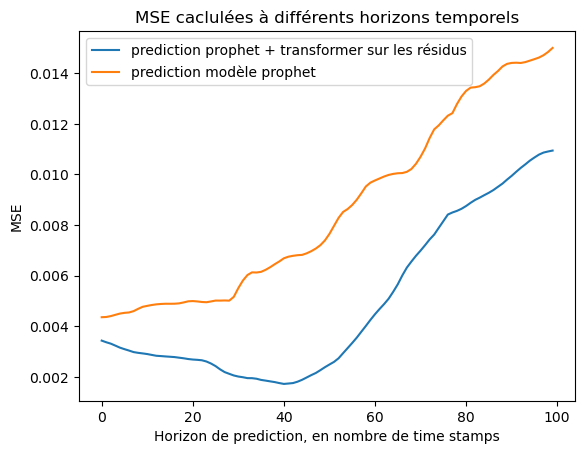

In [61]:
plt.plot(mses_diff_hor_transformer, label='prediction prophet + transformer sur les résidus')
plt.plot(mse_diff_hor_prophet, label='prediction modèle prophet')
plt.xlabel('Horizon de prediction, en nombre de time stamps')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE caclulées à différents horizons temporels')

A titre de comparaison, nous allons maintenant entrainer un modèle LSTM sur les résidus

In [19]:
from LSTM_model import LSTM, training_loop, split_train_test
from torch import nn, optim
import numpy as np

In [ ]:
exogeneous_variables = ['hour_sin', 'dayofweek_sin', 'dayofyear_sin']
df_ = df[['resiudals']+exogeneous_variables]
df_ = np.expand_dims(np.transpose(np.array(df_)), axis=0)
nb_test_vals = 600
alpha=0.1
train_input, train_target, values_to_predict, test_input, test_target = split_train_test(df_, nb_test_sequences=0, prop_seq_test=None, nb_test=nb_test_vals)
print('shp', values_to_predict.shape)
model = LSTM(hidden_layers=15,input_size=4, alpha=alpha)
criterion = nn.MSELoss()
n_epochs = 15
optimiser = optim.Adam(model.parameters(), lr=0.01)
save_fold='LSTM_pred_on_residuals'
predicted_residuals_lstm = training_loop(n_epochs, model, optimiser, criterion, train_input, train_target, values_to_predict,
              test_input, test_target, np.array(df_bretagne["HORODATE"]), save_fold=save_fold, title=f'Half-hourly energy consumption in {region} by delivery point with power under 36 kVA', 
                                        draw_plot_iter=20)

In [ ]:
print('predictions', predictions.shape)

In [ ]:
predicted_signal_plus_residuals_lstm = predicted_residuals_lstm + df_test['prophet_pred'].to_numpy()[:len(predicted_residuals_lstm)]
plt.plot(df_test['HORODATE'], df_test['y'].to_numpy(), label='true signal')
plt.plot(df_test['HORODATE'], df_test['prophet_pred'].to_numpy(), label='prediction modèle prophet')
plt.plot(df_test['HORODATE'], predicted_signal_plus_residuals_lstm, label='prediction prophet + lstm sur les résidus')
plt.xlabel('Date')
plt.ylabel("Energie conommée (Wh/10**9)")
plt.legend()
plt.show()

In [ ]:
mse_prophet_lstm = np.mean((predicted_signal_plus_residuals_lstm - df_test['y'].to_numpy())**2)
print('mse prophet', mse_prophet)
print('mse prophet + transformer on residuals', mse_prophet_transformer)
print('mse prophet + lstm on residuals', mse_prophet_lstm)

In [ ]:
mses_diff_hor_lstm = mse_at_different_horizons(predicted_signal_plus_residuals_lstm, df_test['y'].to_numpy())
plt.plot(mses_diff_hor_transformer, label='prediction prophet + transformer sur les résidus')
plt.plot(mse_diff_hor_prophet, label='prediction modèle prophet')
plt.plot(mses_diff_hor_lstm, label=''prediction prophet + lstm sur les résidus')
plt.xlabel('Horizon de prediction, en nombre de time stamps')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE caclulées à différents horizons temporels')
plt.show()